Here we explore the LDA topic vectors identified based on nouns only in the full data set of coffee shop reviews. PCA is used to visualize.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [3]:
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
reviews = pd.read_csv('./LDAresults/ldatopicweights_allreviews_5topics.csv')
merged = pd.merge(shops,reviews,how='inner',on = ['alias'])


In [4]:
#How is the review data distributed in the LDA topic space?
#Is there a most common type of review?
#What does the distribution look like for different types of coffee shops?
#Are reviews for the same coffee shop in a chain generally closer to one another? This would indicate that 
#What people write about in a review depends what the coffee shop serves
ldavecs = merged[['t0','t1','t2','t3','t4']]


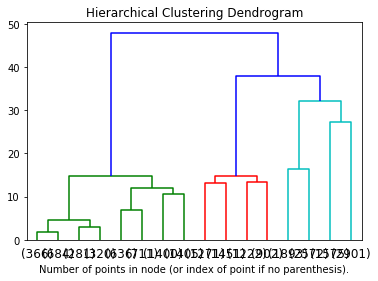

In [7]:
#Determining whether there is any structure to the distribution of LDA vectors.
#Do some topics tend to be correlated with others?
#How can we visualize the distribution of these probability vectors
#Is there a hierarchy to the clustering.  Are some classes of lda vector more similar to one 
#another than other groups? 
#K means works better with spherical clusters but the constraint that the vectors sum to 1 makes it unlikely for this to hold
#Use Euclidean distance because very big differences in a probability class should weigh more than
#many small differences.

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(ldavecs)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



In [56]:
#Visualizing the mean and variance of individual clusters

model = AgglomerativeClustering(n_clusters=6)
labels = model.fit_predict(ldavecs)

0    5803
2    4846
1    2901
3    2572
5    1893
4    1575
Name: labels, dtype: int64
0    0.296223
2    0.247371
1    0.148086
3    0.131291
5    0.096631
4    0.080398
Name: labels, dtype: float64
              t0        t1        t2        t3        t4
labels                                                  
0       0.094181  0.050656  0.105596  0.635287  0.112079
1       0.070588  0.454501  0.152434  0.185441  0.135024
2       0.137999  0.054401  0.544054  0.133999  0.127040
3       0.356525  0.139597  0.125052  0.282608  0.093983
4       0.157391  0.065335  0.064901  0.135649  0.573799
5       0.642653  0.059461  0.132756  0.093437  0.069244
              t0        t1        t2        t3        t4
labels                                                  
0       0.108559  0.059499  0.108031  0.161792  0.121150
1       0.084241  0.186468  0.171680  0.185280  0.145732
2       0.139090  0.063690  0.167293  0.137401  0.153960
3       0.131521  0.132042  0.121601  0.125761  0.092915
4 

Text(0.5, 1.0, 'mean vector\ncluster 5')

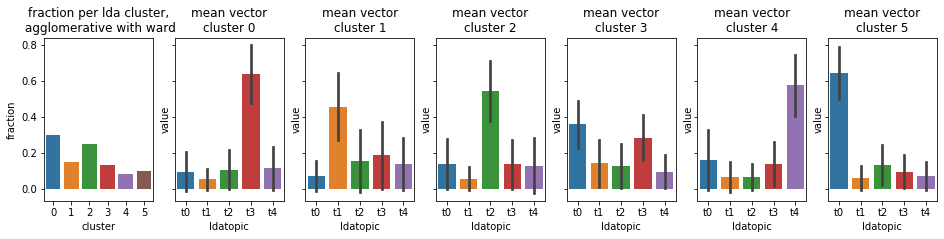

In [99]:
clusteredlda = ldavecs.copy()
clusteredlda['labels'] = labels
print(clusteredlda.labels.value_counts())
fracpercluster = clusteredlda.labels.value_counts()/len(clusteredlda)
print(fracpercluster)

#calculating the mean of vectors assigned to each cluster
clustermeans = clusteredlda.groupby('labels').mean()
print(clustermeans)
clusterstds = clusteredlda.groupby('labels').std()
print(clustervars)

f, (ax1, ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(1, 7, sharey=True, figsize = (16,3))
sns.barplot(x=fracpercluster.index,y=fracpercluster, ax=ax1)
ax1.set_title('fraction per lda cluster,\n agglomerative with ward')
ax1.set_ylabel('fraction')
ax1.set_xlabel('cluster')

clustermeans.reset_index(inplace=True)
longdf = clusteredlda.melt(id_vars=['labels'])
longdf.rename(columns={'variable':'ldatopic'},inplace=True)
print(longdf.head(10))
print(longdf[longdf.labels==0].head(10))

sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==0],ax=ax2,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==1],ax=ax3,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==2],ax=ax4,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==3],ax=ax5,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==4],ax=ax6,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==5],ax=ax7,ci="sd")

ax2.set_title('mean vector\ncluster 0')
ax3.set_title('mean vector\ncluster 1')
ax4.set_title('mean vector\ncluster 2')
ax5.set_title('mean vector\ncluster 3')
ax6.set_title('mean vector\ncluster 4')
ax7.set_title('mean vector\ncluster 5')



The clustering based on Ward/Euclidean distance finds clusters which are primarily disstinguished by the most popular topic.    THe most common cluster is the one in which the coffee topic is strongest, followed by the one  in which the line/time topic.   In the cluster in which the mean food score is highest, the next strongest topics are not far behind.

Plotting the distribution of each topic vector component
For each topic there is a large proportion of reviews with and lda score of 0 for that topic


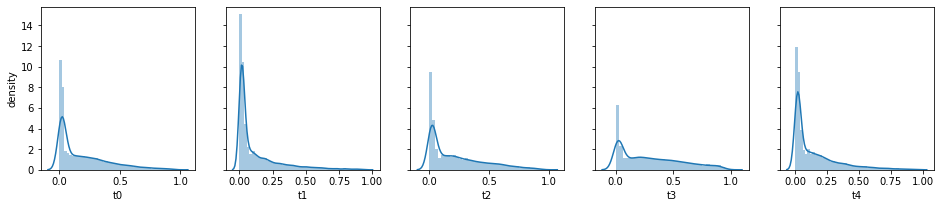

In [52]:
#Plotting the distribution of each lda vector component alone
f, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5, sharey=True, figsize = (16,3))
sns.distplot(ldavecs['t0'],ax=ax1)
sns.distplot(ldavecs['t1'],ax=ax2)
sns.distplot(ldavecs['t2'],ax=ax3)
sns.distplot(ldavecs['t3'],ax=ax4)
sns.distplot(ldavecs['t4'],ax=ax5)
ax1.set_ylabel('density')
print('Plotting the distribution of each topic vector component')
print('For each topic there is a large proportion of reviews with and lda score of 0 for that topic')

In [58]:
from sklearn.decomposition import PCA
X = np.array(ldavecs.values.tolist())
pca = PCA(n_components=3)
pca.fit(X)
Xtransf = pca.transform(X)

0    False
1    False
2    False
Name: name, dtype: bool


Text(0.5, 1.0, 'Sweet Moment')

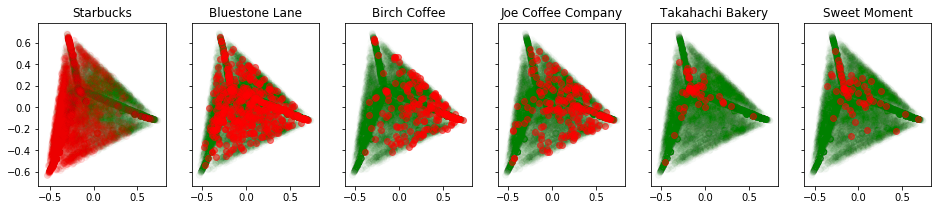

In [59]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

label1 = merged.name == 'Starbucks'
label2 = merged.name == 'Think Coffee'
print(label.head(3))
colors = ['green','red']

f, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1, 6, sharey=True, figsize = (16,3))
ax1.scatter(x=Xtransf[:,0],y=Xtransf[:,1],c=label1,cmap=matplotlib.colors.ListedColormap(colors),alpha=0.01)
Xbsl = np.array([Xtransf[i] for i in range(len(Xtransf)) if merged.name[i] == 'Starbucks'])
ax1.scatter(x=Xbsl[:,0],y=Xbsl[:,1],c='red',alpha = 0.05)
ax1.set_title('Starbucks')


ax2.scatter(x=Xtransf[:,0],y=Xtransf[:,1],c=label2,cmap=matplotlib.colors.ListedColormap(colors),alpha=0.01)
Xbsl = np.array([Xtransf[i] for i in range(len(Xtransf)) if merged.name[i] == 'Bluestone Lane'])
ax2.scatter(x=Xbsl[:,0],y=Xbsl[:,1],c='red',alpha = 0.5)
ax2.set_title('Bluestone Lane')

ax3.scatter(x=Xtransf[:,0],y=Xtransf[:,1],c=label2,cmap=matplotlib.colors.ListedColormap(colors),alpha=0.01)
Xbsl = np.array([Xtransf[i] for i in range(len(Xtransf)) if merged.name[i] == 'Birch Coffee'])
ax3.scatter(x=Xbsl[:,0],y=Xbsl[:,1],c='red',alpha = 0.5)
ax3.set_title('Birch Coffee')

ax4.scatter(x=Xtransf[:,0],y=Xtransf[:,1],c=label2,cmap=matplotlib.colors.ListedColormap(colors),alpha=0.01)
Xbsl = np.array([Xtransf[i] for i in range(len(Xtransf)) if merged.name[i] == 'Joe Coffee Company'])
ax4.scatter(x=Xbsl[:,0],y=Xbsl[:,1],c='red',alpha = 0.5)
ax4.set_title('Joe Coffee Company')

ax5.scatter(x=Xtransf[:,0],y=Xtransf[:,1],c=label2,cmap=matplotlib.colors.ListedColormap(colors),alpha=0.01)
Xbsl = np.array([Xtransf[i] for i in range(len(Xtransf)) if merged.name[i] == 'Takahachi Bakery'])
ax5.scatter(x=Xbsl[:,0],y=Xbsl[:,1],c='red',alpha = 0.5)
ax5.set_title('Takahachi Bakery')

ax6.scatter(x=Xtransf[:,0],y=Xtransf[:,1],c=label2,cmap=matplotlib.colors.ListedColormap(colors),alpha=0.01)
Xbsl = np.array([Xtransf[i] for i in range(len(Xtransf)) if merged.name[i] == 'Sweet Moment'])
ax6.scatter(x=Xbsl[:,0],y=Xbsl[:,1],c='red',alpha = 0.5)
ax6.set_title('Sweet Moment')




Different coffee shops clearly have different distributions of topics in their reviews.  The first principal components has a positive coefficient for coffee related terms (t3), and negative for other terms, especially those related to topic 2 (time, location, morning).    The second principal component is positive for topic 0 (place, table, work, space, seat), and most negative for topic 2(time, location, morning).  It seems like pc2 describes time spent at the place, and pc1 reflects focus on coffee in the review.  The third principal component has t1 (food, sandwiches, breakfast, bread) and t4 (tea, chocolate, flavor, taste) with positive coefficients and t0 (table, work, space) has the most negative component. Together, these 3 principal components explain 85% of the variability in the data set.

In [60]:
print(pca.components_)
print(pca.explained_variance_ratio_)

[[-0.22275479 -0.10291192 -0.45579524  0.85265007 -0.07090838]
 [ 0.65268392  0.1266782  -0.71357128 -0.18570578  0.1195229 ]
 [-0.55938143  0.39747048 -0.28272861 -0.19600229  0.64090348]]
[0.3933152  0.25339106 0.20819849]


Below are the top 10 terms associated with each of the 5 topics.

[(0,
  '0.047*"place" + 0.030*"table" + 0.030*"work" + 0.025*"people" + '
  '0.019*"space" + 0.018*"area" + 0.018*"seat" + 0.018*"staff" + '
  '0.015*"seating" + 0.015*"location"'),
 
 
 (1,
  '0.088*"food" + 0.046*"sandwich" + 0.039*"breakfast" + 0.029*"place" + '
  '0.027*"lunch" + 0.021*"option" + 0.018*"bread" + 0.017*"item" + 0.016*"egg" '
  '+ 0.015*"salad"'),
 
 
 
 (2,
  '0.045*"time" + 0.041*"location" + 0.040*"customer" + 0.038*"service" + '
  '0.035*"drink" + 0.029*"line" + 0.024*"staff" + 0.022*"people" + '
  '0.020*"morning" + 0.019*"minute"'),
 
 
 
 (3,
  '0.225*"coffee" + 0.043*"place" + 0.036*"shop" + 0.029*"milk" + '
  '0.015*"staff" + 0.014*"latte" + 0.014*"service" + 0.012*"area" + '
  '0.012*"spot" + 0.011*"pastry"'),
 
 
 
 (4,
  '0.037*"tea" + 0.035*"chocolate" + 0.022*"drink" + 0.021*"flavor" + '
  '0.019*"cookie" + 0.017*"taste" + 0.016*"milk" + 0.013*"place" + '
  '0.011*"pastry" + 0.011*"cake"')]

Since we are interested in the effect of location on the topics discussed, and not the effect of things served by the restaurant, lets consider the topic distributions in reviews for Starbucks which are spread all over the place.

In [61]:
#There are 104 Starbucks in our data set.
merged[merged.name=='Starbucks'].alias.value_counts()

starbucks-new-york-417    40
starbucks-new-york-256    40
starbucks-new-york-149    40
starbucks-brooklyn-21     40
starbucks-new-york-366    40
                          ..
starbucks-new-york-240    20
starbucks-new-york-138    20
starbucks-new-york-530    19
starbucks-new-york-556    18
starbucks-new-york-250    18
Name: alias, Length: 104, dtype: int64

Even for the same store, the LDA topic vectors look very spread out when projected onto the first two principal components

[2, 2, 2, 2]


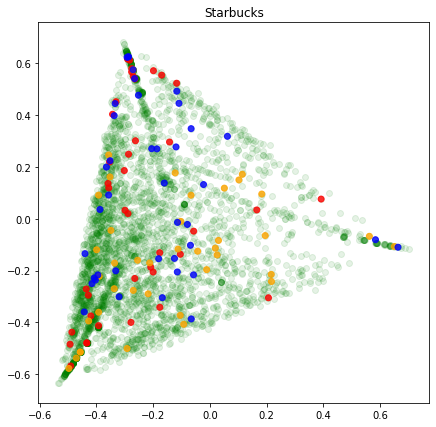

In [84]:
Xsb = np.array([Xtransf[i] for i in range(len(Xtransf)) if merged.name[i] == 'Starbucks'])
sbalias = [merged.alias[i] for i in range(len(Xtransf)) if merged.name[i] == 'Starbucks']

sbset =  ['starbucks-new-york-417','starbucks-new-york-256','starbucks-new-york-149']
Xsb1 = np.array([Xsb[i] for i in range(len(Xsb)) if sbalias[i] in sbset])
sbalias1 = [sbalias[i] for i in range(len(Xsb)) if sbalias[i] in sbset]
for i in range(len(sbalias1)):
    if sbalias1[i] == 'starbucks-new-york-417':
        sbalias1[i] = 1
    if sbalias1[i] == 'starbucks-new-york-256':
        sbalias1[i] = 2
    if sbalias1[i] == 'starbucks-new-york-149':
        sbalias1[i] = 3
        
label = sbalias1

print(label[1:5])
colors = ['orange','red','blue']

f, ax1 = plt.subplots(1,1,sharey=True, figsize = (7,7))

ax1.scatter(x=Xsb[:,0],y=Xsb[:,1],c='green',alpha=0.1)
ax1.set_title('Starbucks')
ax1.scatter(x=Xsb1[:,0],y=Xsb1[:,1],c= label,cmap=matplotlib.colors.ListedColormap(colors),alpha=0.8)


In [89]:
print(merged[merged.alias== 'starbucks-new-york-417'][['t0','t1','t2','t3','t4']])
print(reviews.reviewtxt[15289])
print(reviews.reviewtxt[15265])
print(reviews.reviewtxt[15273])

             t0        t1        t2        t3        t4
15261  0.013590  0.269106  0.689793  0.013516  0.013995
15262  0.199297  0.000000  0.518812  0.061560  0.210748
15263  0.270635  0.178881  0.523457  0.013503  0.013524
15264  0.354047  0.000000  0.162853  0.358099  0.121509
15265  0.000000  0.000000  0.000000  0.783787  0.188191
15266  0.014429  0.014351  0.514012  0.101710  0.355498
15267  0.355039  0.000000  0.140780  0.491095  0.000000
15268  0.411671  0.022605  0.261129  0.282298  0.022297
15269  0.025352  0.025317  0.026232  0.897352  0.025748
15270  0.282674  0.014645  0.522429  0.165811  0.014442
15271  0.206464  0.000000  0.340959  0.373595  0.074779
15272  0.355848  0.011245  0.350669  0.270909  0.011330
15273  0.565250  0.057593  0.275575  0.000000  0.094574
15274  0.255225  0.011928  0.330872  0.390158  0.011817
15275  0.040789  0.040043  0.838767  0.040142  0.040259
15276  0.129801  0.011847  0.191452  0.489991  0.176909
15277  0.172370  0.025011  0.578073  0.025026  0

The above examples illustrate that just becasue a topic is a strong component of a review, does not mean 

In [ ]:
#Let's look at the full distribution of the frequency of coffee related terms in all reviews

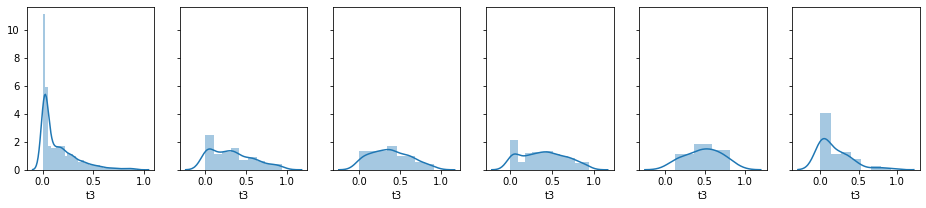

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

f, (ax1, ax2,ax3,ax4,ax5,ax6) = plt.subplots(1, 6, sharey=True, figsize = (16,3))
sns.distplot(ldavecs[merged.name=='Starbucks'].t3,ax=ax1)
sns.distplot(ldavecs[merged.name=='Bluestone Lane'].t3,ax=ax2)
sns.distplot(ldavecs[merged.name=='Think Coffee'].t3,ax=ax3)
sns.distplot(ldavecs[merged.name=='Gregorys Coffee'].t3,ax=ax4)
sns.distplot(ldavecs[merged.name=='Office Coffee'].t3,ax=ax5)
sns.distplot(ldavecs[merged.name=='Sweet Moment'].t3,ax=ax6)


In [ ]:
#Let's summarize the fraction of reviews that talk about coffee

In [18]:
ldacofmen = ldavecs.t3 > 0.3
merged['ldacofmen'] = ldacofmen
merged.groupby('alias')
numcoffeemen = merged.groupby('alias').ldacofmen.sum()
numreviews = merged.groupby('alias').numreviews.mean()



In [24]:
fracldacofmen = numcoffeemen/numreviews

alias
starbucks-new-york-138                                          0.050000
pret-a-manger-new-york-7                                        0.050000
starbucks-new-york-495                                          0.050000
starbucks-new-york-189                                          0.050000
starbucks-new-york-220                                          0.050000
                                                                  ...   
charley-st-new-york                                             0.266667
sweet-moment-new-york                                           0.266667
cha-cha-matcha-new-york-8                                       0.266667
zaros-family-bakery-grand-central-terminal-track-34-new-york    0.272727
joe-and-the-juice-new-york-5                                    0.275000
Length: 200, dtype: float64
alias
2beans-new-york                            0.550000
urban-backyard-new-york                    0.550000
iconic-cafe-new-york-5                     0.555556
r

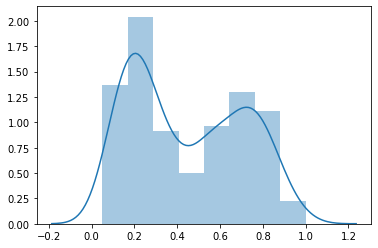

In [31]:
print(fracldacofmen.sort_values().head(200))
print(fracldacofmen.sort_values().tail(200))
sns.distplot(fracldacofmen)

In [ ]:
#Now we look at the geographic distribution of reviews topics
#We first take the mean of the review topic vectors for each coffeeshop
#For each topic, we plot its importance on a m

In [5]:
avgtopicbyalias = merged.groupby('alias')[['t0','t1','t2','t3','t4']].mean()
avgtopicbyalias.reset_index()
avgtopicbyalias = pd.merge(avgtopicbyalias,shops,how='inner',on = ['alias'])


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import descartes

#For creating interactive maps
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

#Let's look at the distribution of the coffee shops on a map
# import libraries
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

import branca

In [18]:
#For each of the 5 topics, plot the topic scores on a map
m_1 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_2 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_3 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_4 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_5 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)

#add shops to the map, color coded by price


colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)    

for i in range(0,len(shops)):
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t0'])).add_to(m_1)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t1'])).add_to(m_2)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t2'])).add_to(m_3)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t3'])).add_to(m_4)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t4'])).add_to(m_5)
    
    
    

colormap1 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap1.caption = 'Average topic t0 fraction'
colormap1.add_to(m_1)

colormap2 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap2.caption = 'Average topic t1 fraction'
colormap2.add_to(m_2)

colormap3 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap3.caption = 'Average topic t2 fraction'
colormap3.add_to(m_3)

colormap4 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap4.caption = 'Average topic t3 fraction'
colormap4.add_to(m_4)

colormap5 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap5.caption = 'Average topic t4 fraction'
colormap5.add_to(m_5)


#display the maps. Work and tables topic

m_1

In [26]:
#Food topic
m_2

In [25]:
#Lines, time, morning topic
m_3

In [23]:
#Coffee Related Topic
m_4

In [24]:
#Tea and Chocolate Topic
m_5

Observations of the geographic distribution of average topic components for coffee shops.

1. For most coffee shops in our data set, the amount of food discussion in a reviews is pretty low. This is also the case for the coffee/tea topic.

2. Average coffee fraction is higher for most coffee shops in the data set. This topic has the highest average review fraction for most coffee shops

3. The tables/seating topic t0, and line/time topic t2 have higher review components than the food (t1) and tea/chocolate (t4) topics.  The line/time topic appears to have a hotspot of high values at the southern tip of manhattan and closer to midtown. The tables/seating topic appears to have the opposite pattern.

In [28]:
#Repeating the process for only starbucks stores - controlling for what is sold
avgtopicbyalias = avgtopicbyalias[avgtopicbyalias.name=='Starbucks']
avgtopicbyalias.head(5)



alias        t0        t1        t2        t3        t4  \
370   starbucks-brooklyn-17  0.299545  0.050494  0.343956  0.178112  0.126482   
371   starbucks-brooklyn-21  0.249395  0.064303  0.428970  0.131532  0.124177   
372   starbucks-brooklyn-40  0.317205  0.072823  0.385653  0.159173  0.062488   
373    starbucks-brooklyn-6  0.211561  0.066899  0.453685  0.130450  0.135876   
374  starbucks-new-york-109  0.323880  0.052136  0.360769  0.188695  0.073291   

                         id       name  is_closed  \
370  mEMPhPK6dSgy5eXS-kYHLg  Starbucks      False   
371  qcnoyytlFIuqlcjDXkXJiw  Starbucks      False   
372  IY8HhDLbJGfHLL8GhaUicw  Starbucks      False   
373  E6h-sMLmF86cuituw5zYxw  Starbucks      False   
374  IQfo2L7qZDZTr29K2NMSSQ  Starbucks      False   

                                         categories  ...  price rating  \
370  [{'alias': 'coffee', 'title': 'Coffee & Tea'}]  ...     $$    3.0   
371  [{'alias': 'coffee', 'title': 'Coffee & Tea'}]  ...     $$    2.5   
372  [{'alias': 'coffee', 'title': 'Coffee & Tea'}]  ...     $$    2.5   
373  [{'alias': 'coffee', 'title': 'Coffee & Tea'}]  ...     $$    2.5   
374  [{'alias': 'coffee', 'title': 'Coffee & Tea'}]  ...     $$    3.0   

     transactions   latitude  longitude  \
370            []  40.694582 -73.993978   
371            []  40.702668 -73.990806   
372            []  40.694975 -73.982911   
373            []  40.694047 -73.986789   
374            []  40.729437 -73.987361   

                                  geometry     catlist numcoffeemen  \
370           POINT (-73.993978 40.694582)  ['coffee']         18.0   
371     POINT (-73.990806294802 40.702668)  ['coffee']         13.0   
372           POINT (-73.982911 40.694975)  ['coffee']         18.0   
373          POINT (-73.9867893 40.694047)  ['coffee']         13.0   
374  POINT (-73.98736099999998 40.7294374)  ['coffee']         21.0   

     numreviews  fraccof  
370          40    0.450  
371          40    0.325  
372          40    0.450  
373          40    0.325  
374          40    0.525  

[5 rows x 21 columns]

In [30]:
#For each of the 5 topics, plot the topic scores on a map
m_1 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_2 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_3 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_4 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_5 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)

#add shops to the map, color coded by price

colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)    

for i in range(0,len(avgtopicbyalias)):
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t0'])).add_to(m_1)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t1'])).add_to(m_2)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t2'])).add_to(m_3)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t3'])).add_to(m_4)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t4'])).add_to(m_5)
    
    
    

colormap1 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap1.caption = 'Average topic t0 fraction'
colormap1.add_to(m_1)

colormap2 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap2.caption = 'Average topic t1 fraction'
colormap2.add_to(m_2)

colormap3 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap3.caption = 'Average topic t2 fraction'
colormap3.add_to(m_3)

colormap4 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap4.caption = 'Average topic t3 fraction'
colormap4.add_to(m_4)

colormap5 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap5.caption = 'Average topic t4 fraction'
colormap5.add_to(m_5)


#display the maps. Work and tables topic

m_1

In [31]:
#Food
m_2

In [32]:
#lines, time, mornig
m_3

In [33]:
#Coffee related topic
m_4

In [34]:
#Tea, chocolate, flavor, cookie, pastry topic
m_5

Summary of starbucks findings
1. Average topic values for starbucks are pretty homogeneous.  Dominated by lines, time, morning (t2) and tables, seating (t0) for all shops.  Average food topic % is low and average tea/chocolate topic % is low too.  The lines/time morning and seating/tables topics show similar geographic heterogeneity.  The fact that these topics show this heterogeneity despite the Starbucks product being the same indicates that geography is affecting the customer experience.  Perhaps there are longer lines in the places where topic t2 is stronger, and more seating/tables where topic t0 is stronger.

In [ ]:
#Lets see if the same geographic patterns show up for the non-Starbucks coffee shops

In [36]:
avgtopicbyalias = merged.groupby('alias')[['t0','t1','t2','t3','t4']].mean()
avgtopicbyalias.reset_index()
avgtopicbyalias = pd.merge(avgtopicbyalias,shops,how='inner',on = ['alias'])

In [37]:
avgtopicbyalias = avgtopicbyalias[avgtopicbyalias.name!='Starbucks']
avgtopicbyalias.head(3)


alias        t0        t1        t2        t3  \
0  11th-street-cafe-new-york  0.170237  0.263571  0.117953  0.326991   
1      12-corners-new-york-4  0.229236  0.051471  0.129740  0.465407   
2            2beans-new-york  0.205819  0.050986  0.098259  0.328570   

         t4                      id              name  is_closed  \
0  0.119889  PW3ty0qUsqcLHKfFlhY-7A  11th Street Cafe      False   
1  0.120559  Rs196agFk9VEW2mHrOwpvw        12 Corners      False   
2  0.313986  2uVut84nu_1J1iXRoXRMiQ            2Beans      False   

                                          categories  ...  price rating  \
0  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...  ...     $$    4.0   
1     [{'alias': 'coffee', 'title': 'Coffee & Tea'}]  ...      $    4.5   
2  [{'alias': 'coffee', 'title': 'Coffee & Tea'},...  ...     $$    4.0   

             transactions   latitude  longitude  \
0  ['pickup', 'delivery']  40.735779 -74.007258   
1                      []  40.718041 -73.997208   
2  ['delivery', 'pickup']  40.751137 -73.978866   

                                   geometry  \
0  POINT (-74.007258262333 40.735778901325)   
1     POINT (-73.99720759999998 40.7180405)   
2             POINT (-73.978866 40.7511373)   

                                        catlist numcoffeemen  numreviews  \
0  ['breakfast_brunch', 'coffee', 'sandwiches']         24.0          40   
1                                    ['coffee']         49.0          60   
2                       ['chocolate', 'coffee']         30.0          40   

    fraccof  
0  0.600000  
1  0.816667  
2  0.750000  

[3 rows x 21 columns]

In [38]:
#For each of the 5 topics, plot the topic scores on a map
m_1 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_2 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_3 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_4 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)
m_5 = folium.Map(location=[40.74,-73.98],tiles='cartodbpositron',zoom_start=13, width = 500, height=350)

#add shops to the map, color coded by price

colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)    

for i in range(0,len(avgtopicbyalias)):
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t0'])).add_to(m_1)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t1'])).add_to(m_2)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t2'])).add_to(m_3)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t3'])).add_to(m_4)
    Circle(
        location=[avgtopicbyalias.iloc[i]['latitude'],avgtopicbyalias.iloc[i]['longitude']],
        radius = 20, 
        color = colorscale(avgtopicbyalias.iloc[i]['t4'])).add_to(m_5)
    
    
    

colormap1 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap1.caption = 'Average topic t0 fraction'
colormap1.add_to(m_1)

colormap2 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap2.caption = 'Average topic t1 fraction'
colormap2.add_to(m_2)

colormap3 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap3.caption = 'Average topic t2 fraction'
colormap3.add_to(m_3)

colormap4 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap4.caption = 'Average topic t3 fraction'
colormap4.add_to(m_4)

colormap5 = branca.colormap.linear.YlOrRd_09.scale(0, 0.5)
colormap5.caption = 'Average topic t4 fraction'
colormap5.add_to(m_5)


#display the maps. Work and tables topic

m_1

In [39]:
#Food topic
m_2

In [40]:
#Lines, time topic
m_3

In [41]:
#Coffee topic
m_4

In [42]:
#Tea/Chocolate topic
m_5

Some similar things show up with the lines/time topic (t2) and the tables seating topic (t0).  In busy places, there will probably be more mentions of lines, while in less  busy places there will be fewer of these.

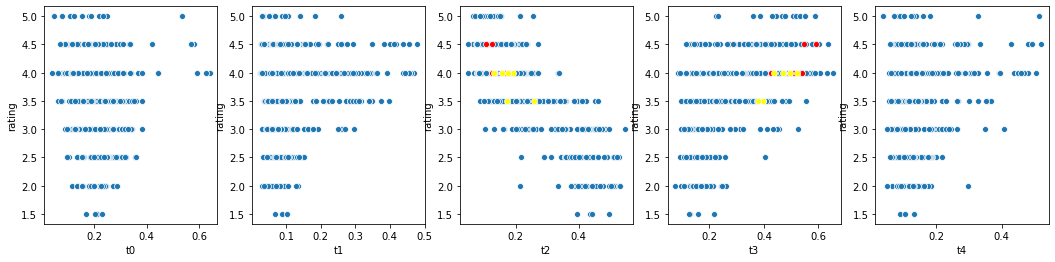

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

#How does the average review topic fraction for a coffee shop relate to its rating?
avgtopicbyalias = merged.groupby('alias')[['t0','t1','t2','t3','t4']].mean()
avgtopicbyalias.reset_index()
avgtopicbyalias = pd.merge(avgtopicbyalias,shops,how='inner',on = ['alias'])

fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(18,4))
sns.scatterplot(avgtopicbyalias.t0,avgtopicbyalias.rating,ax=ax1)
sns.scatterplot(avgtopicbyalias.t1,avgtopicbyalias.rating,ax=ax2)
sns.scatterplot(avgtopicbyalias.t2,avgtopicbyalias.rating,ax=ax3)

sns.scatterplot(avgtopicbyalias[avgtopicbyalias.name=='Birch Coffee'].t2,avgtopicbyalias[avgtopicbyalias.name=='Birch Coffee'].rating,
                    color = 'red',ax=ax3)
sns.scatterplot(avgtopicbyalias[avgtopicbyalias.name=='Joe Coffee Company'].t2,avgtopicbyalias[avgtopicbyalias.name=='Joe Coffee Company'].rating,
                    color = 'yellow',ax=ax3)

sns.scatterplot(avgtopicbyalias.t3,avgtopicbyalias.rating,ax=ax4)
sns.scatterplot(avgtopicbyalias[avgtopicbyalias.name=='Birch Coffee'].t3,avgtopicbyalias[avgtopicbyalias.name=='Birch Coffee'].rating,
                    color = 'red',ax=ax4)
sns.scatterplot(avgtopicbyalias[avgtopicbyalias.name=='Joe Coffee Company'].t3,avgtopicbyalias[avgtopicbyalias.name=='Joe Coffee Company'].rating,
                    color = 'yellow',ax=ax4)


sns.scatterplot(avgtopicbyalias.t4,avgtopicbyalias.rating,ax=ax5)


Places in which the lines/time topic (t2) makes up a big proportion of the review tend to have lower ratings.
Coffee topic (t3) proportion is positively correlated with higher ratings
Food topic (t1) proportion is positively correlated with higher ratings
Chocolate/tea topic (t4) proportion is positivey correlated with higher ratings.  
Tables/seating topic does not have a strong relationship to ratings. Plentiful seating could lead you to write about seating and give a high rating, or not write about seating at all.